**N.B.:** Succinctly merged my analyses into one notebook to work on a directory structured like below.

```text
/scratch/ma3259
├── mariam_effnet_master.ipynb       # Unified notebook for preprocessing, training, and evaluation
├── bmin_final                        # Data storage for DREAMT
│   ├── cached_data
│   └── dreamt
│       ├── cached_data
│       ├── data_100Hz
│       ├── data_64Hz                # The raw data we manipulate (~100 subject CSVs, ~14GB total)
│       ├── data_64hz_processed      # Post-processed, downsampled, and windowed data
│       └── participant_info.csv

# Packages & Data Reading

In [2]:
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
from pathlib import Path
from tqdm import tqdm
import matplotlib.pyplot as plt
from torchmetrics import Accuracy, F1Score, CohenKappa
from torch.utils.data import Dataset, DataLoader, Subset, random_split
from sklearn.metrics import f1_score, cohen_kappa_score, roc_auc_score, roc_curve, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import seaborn as sns
from concurrent.futures import ThreadPoolExecutor, as_completed
from scipy.signal import find_peaks, resample

import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv("/scratch/ma3259/bmin_final/dreamt/data_64Hz/S002_whole_df.csv")
df

,TIMESTAMP,BVP,ACC_X,ACC_Y,ACC_Z,TEMP,EDA,HR,IBI,Sleep_Stage,Obstructive_Apnea,Central_Apnea,Hypopnea,Multiple_Events
0,0.000000,5.14,31.0,8.0,55.0,35.53,0.073005,49.00,NaN,P,NaN,NaN,NaN,NaN
1,0.015625,4.28,31.0,8.0,55.0,35.53,0.073005,49.00,NaN,P,NaN,NaN,NaN,NaN
2,0.031250,3.51,31.0,8.0,55.0,35.53,0.073005,49.00,NaN,P,NaN,NaN,NaN,NaN
3,0.046875,3.02,31.0,8.0,55.0,35.53,0.073005,49.00,NaN,P,NaN,NaN,NaN,NaN
4,0.062500,2.94,28.0,8.0,55.0,35.53,0.073005,49.00,NaN,P,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013692,31463.937500,120.17,-33.0,-24.0,50.0,35.37,0.142168,78.13,1.046875,W,NaN,NaN,NaN,NaN
2013693,31463.953125,106.78,-33.0,-24.0,50.0,35.37,0.142168,78.13,1.046875,W,NaN,NaN,NaN,NaN
2013694,31463.968750,98.52,-33.0,-24.0,51.0,35.37,0.142168,78.13,1.046875,W,NaN,NaN,NaN,NaN
2013695,31463.984375,95.02,-33.0,-24.0,51.0,35.37,0.142168,78.13,1.046875,W,NaN,NaN,NaN,NaN


# II. Wearable-Rate Model

In [ ]:
ROOT_DIR = Path("/scratch/ma3259/bmin_final")
DATA_64HZ_DIR = ROOT_DIR / "dreamt/data_64Hz"
PROCESSED_DIR = ROOT_DIR / "dreamt/data_64hz_processed"
SLEEP_STAGE_MAPPING = {"W": 0, "N1": 1, "N2": 1, "N3": 2, "R": 3}
NUM_CLASSES = 4

In [5]:
def getHR(bvp, fs=64):
    peaks, _ = find_peaks(bvp, distance=int(fs * 0.4))
    rr = np.diff(peaks) / fs
    hr = np.zeros_like(bvp, dtype=np.float32)
    for i in range(len(peaks) - 1):
        hr[peaks[i]:peaks[i+1]] = 60.0 / rr[i]
    return hr

def runPreprocess(file_path, save_dir, fs=64, acc_fs=32, win_sec=300, max_win=30):
    sid = file_path.stem.split("_")[0]
    out_csv = save_dir / f"{sid}_processed.csv"
    acc_csv = save_dir / f"{sid}_acc_32hz.csv"
    print(f"Starting: {file_path.name}")
    if out_csv.exists() and acc_csv.exists():
        print(f"Skipped: {file_path.name}"); return sid

    try:
        df = pd.read_csv(file_path, usecols=["BVP", "TEMP", "ACC_X", "ACC_Y", "ACC_Z", "Sleep_Stage"])
        df = df[df["Sleep_Stage"].isin(SLEEP_STAGE_MAPPING)].dropna()

        hr = getHR(df["BVP"].values, fs)
        bins = np.arange(len(df)) // (win_sec * fs)
        labels = df["Sleep_Stage"].map(SLEEP_STAGE_MAPPING).values
        temp = df["TEMP"].values

        hr_ds = pd.Series(hr).groupby(bins).mean().reindex(range(max_win), fill_value=np.nan)
        temp_ds = pd.Series(temp).groupby(bins).mean().reindex(range(max_win), fill_value=np.nan)
        label_ds = pd.Series(labels).groupby(bins).agg(lambda x: x.mode().iloc[0] if not x.mode().empty else -1).reindex(range(max_win), fill_value=-1)

        df_out = pd.DataFrame({"hr_5min": hr_ds.ffill().bfill(), "temp_5min": temp_ds.ffill().bfill(), "label_5min": label_ds})
        df_out.to_csv(out_csv, index=False)

        acc_mag = np.sqrt(df["ACC_X"]**2 + df["ACC_Y"]**2 + df["ACC_Z"]**2)
        acc_resampled = resample(acc_mag, int(len(acc_mag) * acc_fs / fs)).astype(np.float32)
        pd.DataFrame({"acc_32hz": acc_resampled}).to_csv(acc_csv, index=False)

        print(f"Done: {file_path.name}")
    except Exception as e:
        print(f"Error: {file_path.name} | {e}")
    return sid

def runAllPreprocessing():
    PROCESSED_DIR.mkdir(parents=True, exist_ok=True)
    files = sorted(DATA_64HZ_DIR.glob("*_whole_df.csv"))
    with ThreadPoolExecutor(max_workers=12) as ex:
        list(as_completed([ex.submit(runPreprocess, f, PROCESSED_DIR) for f in files]))
        
# runAllPreprocessing()

In [6]:
class SEBlock1D(nn.Module):
    def __init__(self, ch, r=4):
        super().__init__()
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Sequential(nn.Linear(ch, ch // r), nn.ReLU(), nn.Linear(ch // r, ch), nn.Sigmoid())
    def forward(self, x):
        w = self.fc(self.pool(x).squeeze(-1)).unsqueeze(-1)
        return x * w

class DepthwiseSeparableConv1D(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.dw = nn.Conv1d(in_ch, in_ch, 3, padding=1, groups=in_ch, bias=False)
        self.pw = nn.Conv1d(in_ch, out_ch, 1, bias=False)
        self.bn = nn.BatchNorm1d(out_ch)
        self.se = SEBlock1D(out_ch)
        self.act = nn.SiLU()
    def forward(self, x):
        return self.act(self.se(self.bn(self.pw(self.dw(x)))))

class EffNet1D(nn.Module):
    def __init__(self):
        super().__init__()
        self.stage1 = DepthwiseSeparableConv1D(3, 32)
        self.stage2 = DepthwiseSeparableConv1D(32, 64)
        self.stage3 = DepthwiseSeparableConv1D(64, 128)
        self.out = nn.Conv1d(128, NUM_CLASSES, 1)
    def forward(self, x):
        x = self.stage1(x)
        x = self.stage2(x)
        x = self.stage3(x)
        x = self.out(x)
        return x.permute(0, 2, 1)

def forward_fill(x: torch.Tensor) -> torch.Tensor:
    single = False
    if x.dim() == 1:
        x = x.unsqueeze(1)
        single = True
    T, C = x.shape
    for c in range(C):
        if torch.isnan(x[0, c]):
            x[0, c] = 0.0
        for t in range(1, T):
            if torch.isnan(x[t, c]):
                x[t, c] = x[t - 1, c]
    return x.squeeze(1) if single else x

In [8]:
SEQUENCE_LEN = 30

class DreamtDataset(Dataset):
    def __init__(self, data_dir):
        self.hr_temp = sorted(Path(data_dir).glob("*_processed.csv"))
        self.acc = sorted(Path(data_dir).glob("*_acc_32hz.csv"))
    def __len__(self): return len(self.hr_temp)
    def __getitem__(self, i):
        df = pd.read_csv(self.hr_temp[i])
        acc = pd.read_csv(self.acc[i])
        hr = df["hr_5min"].ffill().bfill()[:SEQUENCE_LEN].values.astype(np.float32)
        temp = df["temp_5min"].ffill().bfill()[:SEQUENCE_LEN].values.astype(np.float32)
        label = df["label_5min"].values.astype(np.int64)[:SEQUENCE_LEN]
        acc_seq = acc["acc_32hz"].values.astype(np.float32)[:SEQUENCE_LEN*9600]
        acc_mean = acc_seq.reshape(SEQUENCE_LEN, -1).mean(axis=1)
        x = np.stack([hr, temp, acc_mean], axis=0)  # shape: [3, 30]
        return {"x": torch.tensor(x), "label": torch.tensor(label)}

Class 0: 940 samples
Class 1: 1764 samples
Class 2: 173 samples
Class 3: 123 samples


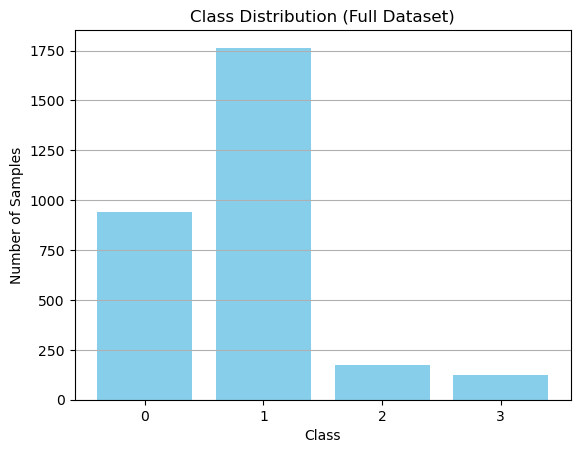

In [9]:
# Data Label Distribution
dataset = DreamtDataset(PROCESSED_DIR)
all_labels = []
for i in range(len(dataset)):
    all_labels.extend(dataset[i]["label"].numpy())
all_labels = np.array(all_labels)

all_labels = all_labels[all_labels != -1]

classes, counts = np.unique(all_labels, return_counts=True)

for cls, cnt in zip(classes, counts):
    print(f"Class {cls}: {cnt} samples")

plt.bar(classes, counts, color='skyblue')
plt.xticks(classes)
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.title('Class Distribution (Full Dataset)')
plt.grid(axis='y')
plt.show()


Final Test Metrics:
Accuracy: 0.69
F1 Score (macro): 0.33419278732726665
Cohen’s Kappa: 0.29641398093508853
AUC (macro): 0.6515349228375487


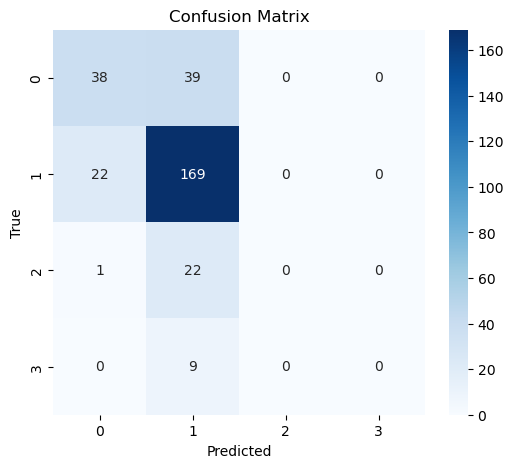

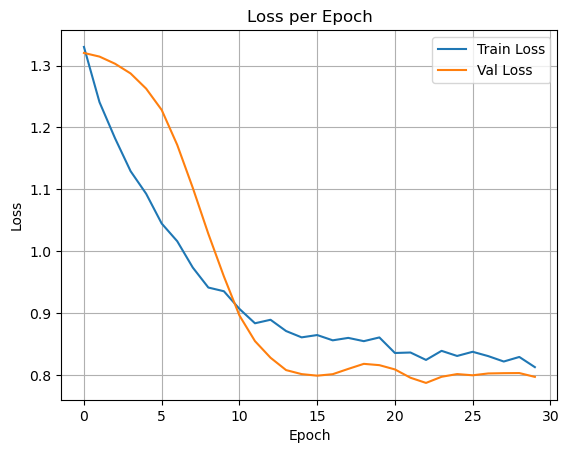

In [17]:
BATCH_SIZE = 16
EPOCHS = 30

dataset = DreamtDataset(PROCESSED_DIR)

indices = np.arange(len(dataset))
train_idx, temp_idx = train_test_split(indices, test_size=0.2, random_state=42)
val_idx, test_idx = train_test_split(temp_idx, test_size=0.5, random_state=42)

train_set = Subset(dataset, train_idx)
val_set = Subset(dataset, val_idx)
test_set = Subset(dataset, test_idx)

train_loader = DataLoader(train_set, BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_set, BATCH_SIZE, shuffle=False, num_workers=2)
test_loader = DataLoader(test_set, BATCH_SIZE, shuffle=False, num_workers=2)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EffNet1D().to(device)
criterion = nn.CrossEntropyLoss(ignore_index=-1)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
train_losses, val_losses = [], []
best_val_loss = float('inf')

for epoch in range(EPOCHS):
    model.train()
    train_loss = 0
    for batch in train_loader:
        x, y = batch["x"].to(device), batch["label"].to(device).long()
        logits = model(x)
        loss = criterion(logits.reshape(-1, NUM_CLASSES), y.reshape(-1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_losses.append(train_loss / len(train_loader))

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in val_loader:
            x, y = batch["x"].to(device), batch["label"].to(device).long()
            logits = model(x)
            loss = criterion(logits.reshape(-1, NUM_CLASSES), y.reshape(-1))
            val_loss += loss.item()
    val_losses.append(val_loss / len(val_loader))

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "best_effnet1d.pt")

model.load_state_dict(torch.load("best_effnet1d.pt"))
model.eval()
y_true, y_pred, y_probs = [], [], []
with torch.no_grad():
    for batch in test_loader:
        x, y = batch["x"].to(device), batch["label"].to(device).long()
        logits = model(x)
        probs = torch.softmax(logits, dim=-1)
        preds = torch.argmax(probs, dim=-1)
        y_true.extend(y.view(-1).cpu().numpy())
        y_pred.extend(preds.view(-1).cpu().numpy())
        y_probs.extend(probs.reshape(-1, NUM_CLASSES).cpu().numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_probs = np.array(y_probs)

mask = y_true != -1
y_true_masked = y_true[mask]
y_pred_masked = y_pred[mask]
y_true_bin = label_binarize(y_true_masked, classes=np.arange(NUM_CLASSES))
y_prob_bin = y_probs[mask]

print("\nFinal Test Metrics:")
print("Accuracy:", (y_true_masked == y_pred_masked).mean())
print("F1 Score (macro):", f1_score(y_true_masked, y_pred_masked, average='macro'))
print("Cohen’s Kappa:", cohen_kappa_score(y_true_masked, y_pred_masked))

try:
    auc_score = roc_auc_score(y_true_bin, y_prob_bin, average='macro', multi_class='ovr')
    print("AUC (macro):", auc_score)
except:
    print("AUC not computed")

cm = confusion_matrix(y_true_masked, y_pred_masked, labels=np.arange(NUM_CLASSES))
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.arange(NUM_CLASSES), yticklabels=np.arange(NUM_CLASSES))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title("Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()

# III. Temporal Delta Memory Model

In [3]:
DATA_DIR = "/scratch/ma3259/bmin_final/dreamt/data_64Hz"
SLEEP_STAGE_MAPPING = {"W": 0, "N1": 1, "N2": 1, "N3": 2, "R": 3}
SEQUENCE_LEN = 30
NUM_CLASSES=4
BATCH_SIZE = 16
EPOCHS = 50

In [4]:
def getHR(bvp, fs=64):
    peaks, _ = find_peaks(bvp, distance=int(fs * 0.4))
    rr = np.diff(peaks) / fs
    hr = np.zeros_like(bvp, dtype=np.float32)
    for i in range(len(peaks) - 1):
        hr[peaks[i]:peaks[i+1]] = 60.0 / rr[i]
    return hr

In [5]:
def train(offset_minutes, offset_count):
    class SEBlock1D(nn.Module):
        def __init__(self, ch, r=4):
            super().__init__()
            self.pool = nn.AdaptiveAvgPool1d(1)
            self.fc = nn.Sequential(nn.Linear(ch, ch // r), nn.ReLU(), nn.Linear(ch // r, ch), nn.Sigmoid())
        def forward(self, x):
            w = self.fc(self.pool(x).squeeze(-1)).unsqueeze(-1)
            return x * w
    
    class DepthwiseSeparableConv1D(nn.Module):
        def __init__(self, in_ch, out_ch):
            super().__init__()
            self.dw = nn.Conv1d(in_ch, in_ch, 3, padding=1, groups=in_ch, bias=False)
            self.pw = nn.Conv1d(in_ch, out_ch, 1, bias=False)
            self.bn = nn.BatchNorm1d(out_ch)
            self.se = SEBlock1D(out_ch)
            self.act = nn.SiLU()
        def forward(self, x):
            return self.act(self.se(self.bn(self.pw(self.dw(x)))))
    
    class EffNet1D(nn.Module):
        def __init__(self):
            super().__init__()
            self.stage1 = DepthwiseSeparableConv1D(3 * offset_count + 4, 32)
            self.stage2 = DepthwiseSeparableConv1D(32, 64)
            self.stage3 = DepthwiseSeparableConv1D(64, 128)
            self.out = nn.Conv1d(128, NUM_CLASSES, 1)
        def forward(self, x):
            x = self.stage1(x)
            x = self.stage2(x)
            x = self.stage3(x)
            x = self.out(x)
            return x.permute(0, 2, 1)

    class DreamtDataset(Dataset):
        def __init__(self, files):
            self.x = []
            self.label = []
            
            for file_index, file in enumerate(files):
                print("\rLoaded {} of {} files".format(file_index, len(files)), end="")
                in_df = pd.read_csv(file, usecols=["BVP", "TEMP", "ACC_X", "ACC_Y", "ACC_Z", "TIMESTAMP", "Sleep_Stage"])
                in_df["ACC"] = np.sqrt(in_df["ACC_X"]**2 + in_df["ACC_Y"]**2 + in_df["ACC_Z"]**2)
                in_df["HR"] = getHR(in_df["BVP"].values, 64)
        
                bins = np.arange(len(in_df)) // 320
        
                df = pd.DataFrame()
                df["ACC"] = pd.Series(in_df["ACC"]).groupby(bins).mean()
                df["HR"] = pd.Series(in_df["HR"]).groupby(bins).mean()
                df["TEMP"] = pd.Series(in_df["TEMP"]).groupby(bins).mean()
                df["ACC"] = (df["ACC"] - df["ACC"].mean()) / df["ACC"].std()
                df["HR"] = (df["HR"] - df["HR"].mean()) / df["HR"].std()
                df["TEMP"] = (df["TEMP"] - df["TEMP"].mean()) / df["TEMP"].std()
                df["TIMESTAMP"] = pd.Series(in_df["TIMESTAMP"]).groupby(bins).mean()
                df["Sleep_Stage"] = pd.Series(in_df["Sleep_Stage"]).groupby(bins).agg(lambda x: x.mode().iloc[0] if not x.mode().empty else -1)
    
                for i in range(1, offset_count + 1):
                    df["ACC_{}M_DELTA".format(i * offset_minutes)] = df["ACC"].shift(i * offset_minutes * 12).fillna(-100) - df["ACC"]
                    df["HR_{}M_DELTA".format(i * offset_minutes)] = df["HR"].shift(i * offset_minutes * 12).fillna(-100) - df["HR"]
                    df["TEMP_{}M_DELTA".format(i * offset_minutes)] = df["TEMP"].shift(i * offset_minutes * 12).fillna(-100) - df["TEMP"]
    
                df = df[df["Sleep_Stage"].isin(SLEEP_STAGE_MAPPING)].dropna()
                df["Sleep_Stage"] = df["Sleep_Stage"].map(SLEEP_STAGE_MAPPING)
    
                features = []
                l = len(df) // SEQUENCE_LEN
                
                features.append(torch.tensor(np.split(df["ACC"].values.astype(np.float32)[:l * SEQUENCE_LEN], l)))
                features.append(torch.tensor(np.split(df["HR"].values.astype(np.float32)[:l * SEQUENCE_LEN], l)))
                features.append(torch.tensor(np.split(df["TEMP"].values.astype(np.float32)[:l * SEQUENCE_LEN], l)))
                features.append(torch.tensor(np.split(df["TIMESTAMP"].values.astype(np.float32)[:l * SEQUENCE_LEN], l)))
                
                for i in range(1, offset_count + 1):
                    features.append(torch.tensor(np.split(df["ACC_{}M_DELTA".format(i * offset_minutes)].values.astype(np.float32)[:l * SEQUENCE_LEN], l)))
                    features.append(torch.tensor(np.split(df["HR_{}M_DELTA".format(i * offset_minutes)].values.astype(np.float32)[:l * SEQUENCE_LEN], l)))
                    features.append(torch.tensor(np.split(df["TEMP_{}M_DELTA".format(i * offset_minutes)].values.astype(np.float32)[:l * SEQUENCE_LEN], l)))
    
                self.x.extend(list(zip(*features)))
                self.label.extend(torch.tensor(np.split(df["Sleep_Stage"].astype(np.int64).values[:l * SEQUENCE_LEN], l)))
            print()
    
        def __len__(self):
            return len(self.label)
        def __getitem__(self, idx):
            return {"x": torch.stack(self.x[idx]), "label": self.label[idx]}

    files = [f for f in sorted(Path(DATA_DIR).glob("*_whole_df.csv"))]
    train_files, temp_files = train_test_split(files, test_size=0.2, random_state=42)
    val_files, test_files = train_test_split(temp_files, test_size=0.5, random_state=42)
    
    train_set = DreamtDataset(train_files)
    val_set = DreamtDataset(val_files)
    test_set = DreamtDataset(test_files)

    train_loader = DataLoader(train_set, BATCH_SIZE, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_set, BATCH_SIZE, shuffle=False, num_workers=2)
    test_loader = DataLoader(test_set, BATCH_SIZE, shuffle=False, num_workers=2)
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = EffNet1D().to(device)
    criterion = nn.CrossEntropyLoss(ignore_index=-1)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    train_losses, val_losses = [], []
    best_val_loss = float('inf')
    
    total_batches = len(train_loader)

    for epoch in range(EPOCHS):
        model.train()
        train_loss = 0
        for batch_idx, batch in enumerate(train_loader):
            x, y = batch["x"].to(device), batch["label"].to(device).long()
            logits = model(x)
            loss = criterion(logits.reshape(-1, NUM_CLASSES), y.reshape(-1))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            print(f"\rEpoch {epoch+1} Train [{batch_idx+1}/{total_batches}]", end="")
    
        train_losses.append(train_loss / len(train_loader))
    
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in val_loader:
                x, y = batch["x"].to(device), batch["label"].to(device).long()
                logits = model(x)
                loss = criterion(logits.reshape(-1, NUM_CLASSES), y.reshape(-1))
                val_loss += loss.item()
        val_losses.append(val_loss / len(val_loader))
    
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), "best_effnet1d.pt")
    
    model.load_state_dict(torch.load("best_effnet1d.pt"))
    model.eval()
    y_true, y_pred, y_probs = [], [], []
    with torch.no_grad():
        for batch in test_loader:
            x, y = batch["x"].to(device), batch["label"].to(device).long()
            logits = model(x)
            probs = torch.softmax(logits, dim=-1)
            preds = torch.argmax(probs, dim=-1)
            y_true.extend(y.view(-1).cpu().numpy())
            y_pred.extend(preds.view(-1).cpu().numpy())
            y_probs.extend(probs.reshape(-1, NUM_CLASSES).cpu().numpy())

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_probs = np.array(y_probs)
    
    mask = y_true != -1
    y_true_masked = y_true[mask]
    y_pred_masked = y_pred[mask]
    y_true_bin = label_binarize(y_true_masked, classes=np.arange(NUM_CLASSES))
    y_prob_bin = y_probs[mask]

    print()
    print("Final Test Metrics:")
    print("Accuracy:", (y_true_masked == y_pred_masked).mean())
    print("F1 Score (macro):", f1_score(y_true_masked, y_pred_masked, average='macro'))
    print("Cohen’s Kappa:", cohen_kappa_score(y_true_masked, y_pred_masked))
    
    try:
        auc_score = roc_auc_score(y_true_bin, y_prob_bin, average='macro', multi_class='ovr')
        print("AUC (macro):", auc_score)
    except:
        print("AUC not computed")
    
    cm = confusion_matrix(y_true_masked, y_pred_masked, labels=np.arange(NUM_CLASSES))
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.arange(NUM_CLASSES), yticklabels=np.arange(NUM_CLASSES))
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()
    
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.title("Loss per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid()
    plt.show()

Loaded 79 of 80 files
Loaded 9 of 10 files
Loaded 9 of 10 files
Epoch 100 Train [802/802]
Final Test Metrics:
Accuracy: 0.6507685828595494
F1 Score (macro): 0.2849689101519351
Cohen’s Kappa: 0.15781860527303126
AUC (macro): 0.7440647458461134


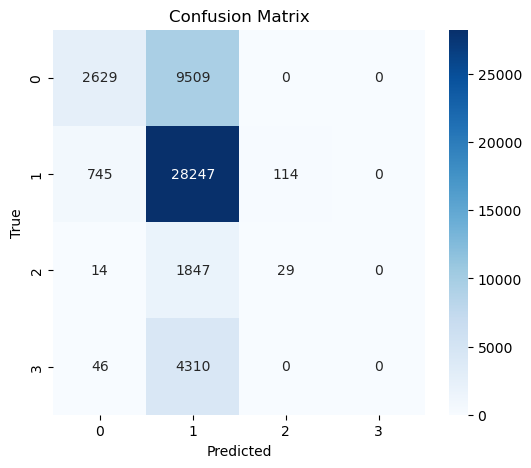

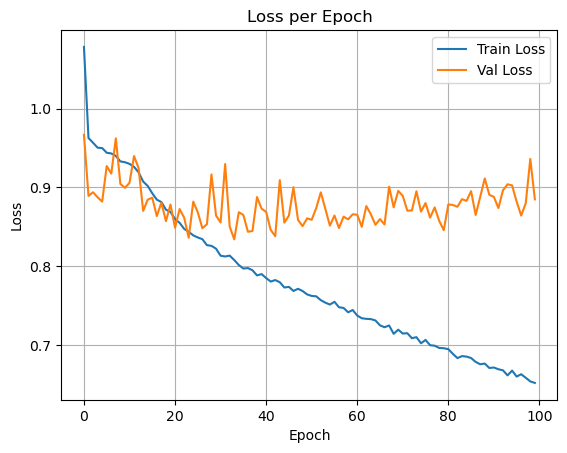

In [28]:
train(offset_minutes=1, offset_count=120)

Loaded 79 of 80 files
Loaded 9 of 10 files
Loaded 9 of 10 files
Epoch 50 Train [802/802]
Final Test Metrics:
Accuracy: 0.6567909033480733
F1 Score (macro): 0.3071185904735449
Cohen’s Kappa: 0.21281793438714747
AUC (macro): 0.7232793409233356


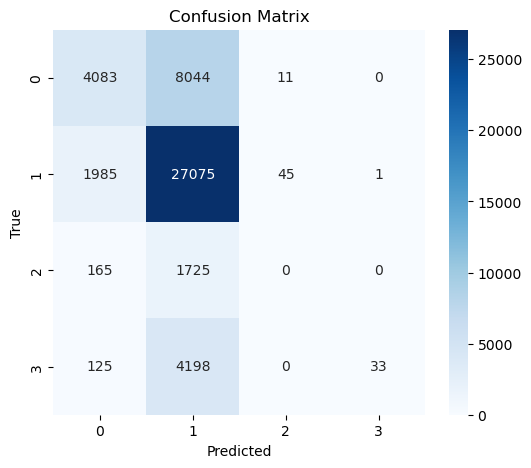

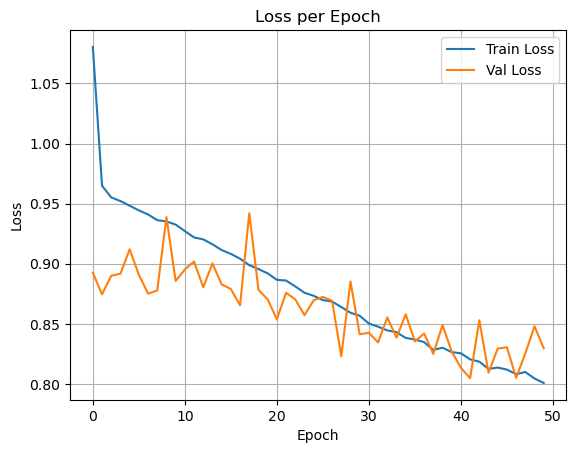

In [33]:
train(offset_minutes=2, offset_count=120)

Loaded 79 of 80 files
Loaded 9 of 10 files
Loaded 9 of 10 files
Epoch 50 Train [802/802]
Final Test Metrics:
Accuracy: 0.6421773004843125
F1 Score (macro): 0.27516843951521397
Cohen’s Kappa: 0.14454245925550013
AUC (macro): 0.710091676072765


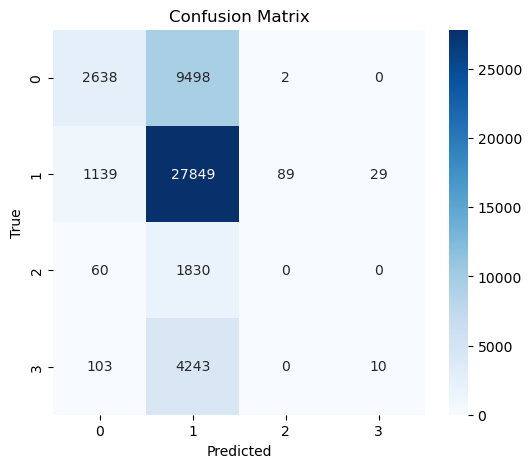

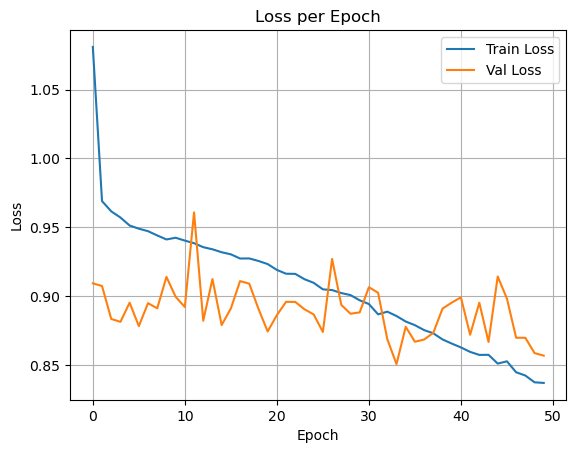

In [24]:
train(offset_minutes=3, offset_count=120)

Loaded 79 of 80 files
Loaded 9 of 10 files
Loaded 9 of 10 files
Epoch 50 Train [802/802]
Final Test Metrics:
Accuracy: 0.6700357970098968
F1 Score (macro): 0.3302330055990221
Cohen’s Kappa: 0.26031203585945306
AUC (macro): 0.7336194401515488


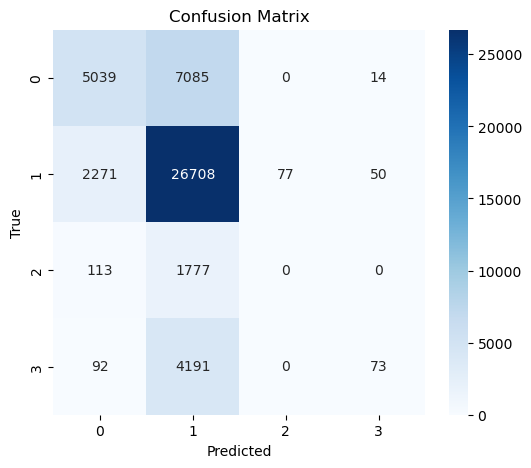

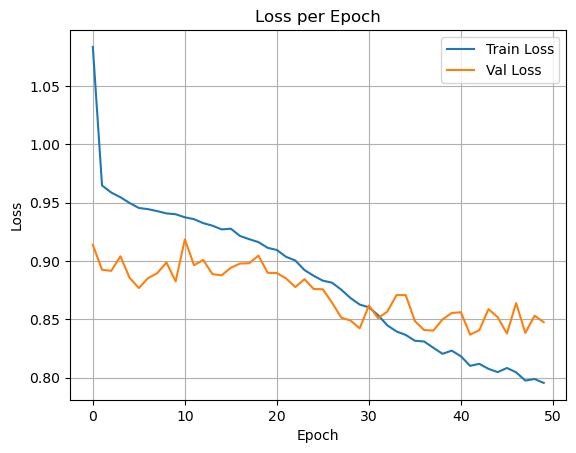

In [25]:
train(offset_minutes=4, offset_count=120)

Loaded 79 of 80 files
Loaded 9 of 10 files
Loaded 9 of 10 files
Epoch 50 Train [802/802]
Final Test Metrics:
Accuracy: 0.6570225310591703
F1 Score (macro): 0.30350780357022444
Cohen’s Kappa: 0.21028812915176842
AUC (macro): 0.7335927298644193


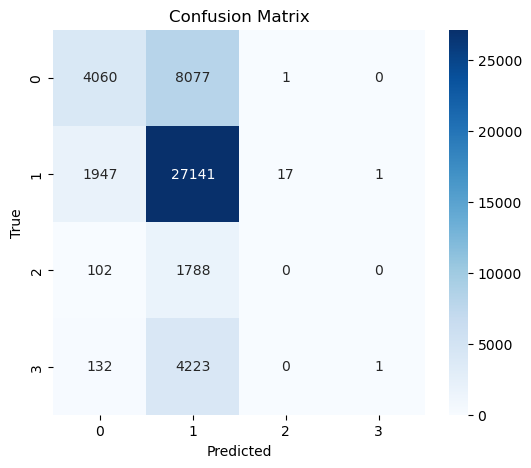

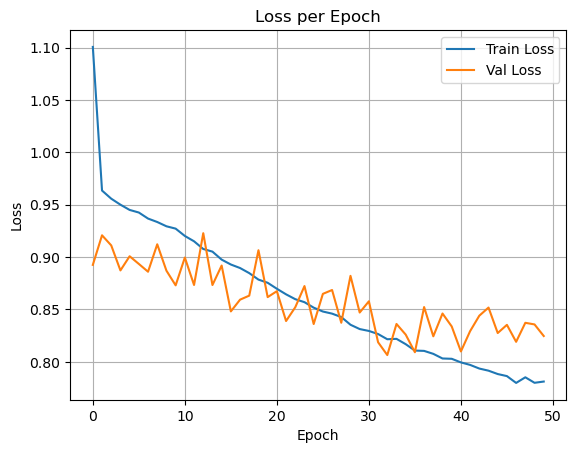

In [6]:
train(offset_minutes=1, offset_count=240)